In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import torch

In [ ]:
#  Average results on IN-C (for all corruption types and severity levels)
Corruptions_list = ['brightness','contrast','defocus_blur','elastic_transform',
                'fog','frost','glass_blur', 'jpeg_compression','motion_blur','pixelate',
                  'shot_noise','snow', 'zoom_blur','gaussian_noise', 'impulse_noise']

sav_dir = 'IN_C/'
model_name_abbr = 'rn18'
trial_index = 'test1'


for stage in range(3,7):
    kong =  [0 for _ in range(1000)]
    d = {'Class_id': [i for i in range(1000)], 'Org_acc':kong,'Org_DFM_acc': kong, 
        'Corrupt_acc': kong, 'Corrupt_DFM_acc': kong, 'Delta': kong, 'Delta_DFM':kong
        }

    d = pd.DataFrame(data=d)
    for severity in range(1,6):
        for class_id in range(1000):
            for corruption in Corruptions_list:
                results= pd.read_csv(sav_dir + model_name_abbr + '_s' + str(stage) + trial_index  +'severity'+ str(severity)  +corruption+ '.csv')
                d.loc[class_id,'Org_acc'] += results.loc[class_id,'Org_acc']/5/len(Corruptions_list)
                d.loc[class_id,'Org_DFM_acc'] += results.loc[class_id,'Org_DFM_acc']/5/len(Corruptions_list)
                d.loc[class_id,'Corrupt_acc'] += results.loc[class_id,'Corrupt_acc']/5/len(Corruptions_list)
                d.loc[class_id,'Corrupt_DFM_acc'] += results.loc[class_id,'Corrupt_DFM_acc']/5/len(Corruptions_list)
        
    d.to_csv(trial_index+model_name_abbr+'_performance_summary_stage'+str(stage)+'.csv')


In [ ]:
#  Average results on IN-v2 (for all the three subsets)

Corruptions_list = ['INmatch','INthred','INtop']#

sav_dir = 'INv2/' 
model_name_abbr= 'rn18'
trial_index = 'test1'

for stage in range(3,7):
    kong =  [0 for _ in range(1000)]
    d = {'Class_id': [i for i in range(1000)], 'Org_acc':kong,'Org_DFM_acc': kong, 
        'Corrupt_acc': kong, 'Corrupt_DFM_acc': kong, 'Delta': kong, 'Delta_DFM':kong
        }

    d = pd.DataFrame(data=d)
    
    for class_id in range(1000):
        for corruption in Corruptions_list:
            results= pd.read_csv(sav_dir + model_name_abbr + '_s' + str(stage) + trial_index  + corruption+ '.csv')
            d.loc[class_id,'Org_acc'] += results.loc[class_id,'Org_acc']/len(Corruptions_list)
            d.loc[class_id,'Org_DFM_acc'] += results.loc[class_id,'Org_DFM_acc']/len(Corruptions_list)
            d.loc[class_id,'Corrupt_acc'] += results.loc[class_id,'Corrupt_acc']/len(Corruptions_list)
            d.loc[class_id,'Corrupt_DFM_acc'] += results.loc[class_id,'Corrupt_DFM_acc']/len(Corruptions_list)
        

    d.to_csv(trial_index+model_name_abbr+'_performance_summary_stage'+str(stage)+'INv2.csv')


In [ ]:
# remain only results of 200 classes from ImageNet-1k as IN-r contains only 200 classes
sav_dir = 'IN_r/'
model_name_abbr = 'rn18'
trial_index = 'test1'


for stage in ([3]):
    kong =  [0 for _ in range(200)]
    d = {'Class_id': [i for i in range(200)], 'Org_acc':kong,'Org_DFM_acc': kong, 
        'Corrupt_acc': kong, 'Corrupt_DFM_acc': kong
        }

    d = pd.DataFrame(data=d)
    class_id = 0
    for s_i in range(1000):
        results= pd.read_csv(sav_dir + model_name_abbr + '_s' + str(stage) + trial_index  + 'INr.csv')
        if results.loc[s_i,'Org_DFM_acc'] == 0 and results.loc[s_i,'Org_acc'] == 0:
            continue
        else:

            d.loc[class_id,'Org_acc'] = results.loc[s_i,'Org_acc']
            d.loc[class_id,'Org_DFM_acc'] = results.loc[s_i,'Org_DFM_acc']
            d.loc[class_id,'Corrupt_acc'] = results.loc[s_i,'Corrupt_acc']
            d.loc[class_id,'Corrupt_DFM_acc'] = results.loc[s_i,'Corrupt_DFM_acc']
            d.loc[class_id,'Class_id'] = results.loc[s_i,'Class_id']
            class_id += 1
        

    d.to_csv(trial_index+model_name_abbr+'_performance_summary_stage'+str(stage)+'INr.csv')

### plot AverageTPR-t curve

In [3]:
def get_results(indices,acc_name):
    per_degrad = 0
    for ind in indices:
        per_degrad += results.loc[ind.item(),acc_name]
    try:
        per_degrad /= len(indices)
    except:
        per_degrad = 0
    return per_degrad

def get_threshold_results(acc1,acc2):
    org_dfm = torch.tensor(results['Org_DFM_acc'])
    S_de = []
    N_de = []
    S_DFM_de = []
    N_DFM_de = []
    sizes_shortcut = []
    sizes_normal = []

    for t in ([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]):
        indices_shortcut = (org_dfm >t).nonzero()
        indices_normal = (org_dfm <=t).nonzero()
        size_shortcut = len(indices_shortcut)/( len(indices_shortcut)+ len(indices_normal))*100*2
        size_normal = len(indices_normal)/( len(indices_shortcut)+ len(indices_normal))*100*2
        sizes_shortcut.append(size_shortcut)
        sizes_normal.append(size_normal)

        per_degrad = get_results(indices_shortcut,acc1)
        S_de.append(per_degrad)

        per_degrad = get_results(indices_normal,acc1)
        N_de.append(per_degrad)

        per_degrad = get_results(indices_shortcut,acc2)
        S_DFM_de.append(per_degrad)

        per_degrad = get_results(indices_normal,acc2 )
        N_DFM_de.append(per_degrad)

    return S_de,N_de,S_DFM_de,N_DFM_de,sizes_shortcut,sizes_normal


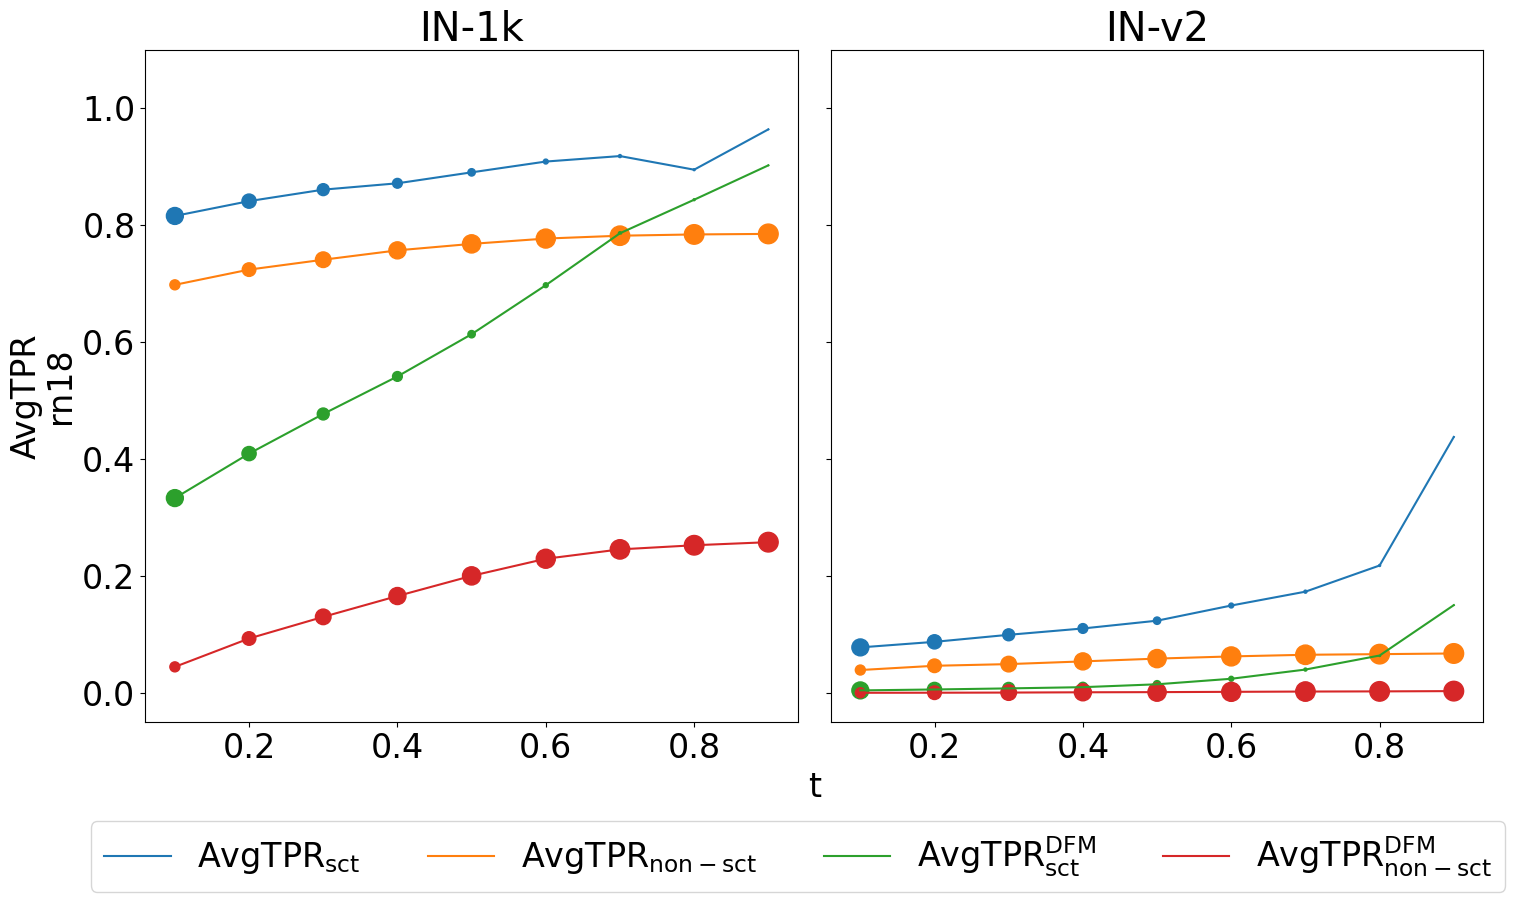

In [24]:

model_name = 'rn18' #: 'rn50'. 'cct', 'vitb'
plt.rcParams.update({'font.size': 24})

fig, axs = plt.subplots(1,2,sharey=True)
fig.set_figheight(8)
fig.set_figwidth(15)
fig.tight_layout()
plt.subplots_adjust(hspace=0.05,wspace=0.05)
direc = './FGSM/'
trial_index = 'test1'
stage = 's6'

results= pd.read_csv(direc + model_name + '_' + stage + trial_index   + 'fgsm.csv'  )
S_de,N_de,S_DFM_de,N_DFM_de,sizes_shortcut,sizes_normal = get_threshold_results('Corrupt_acc','Corrupt_DFM_acc')
x = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
axs[1].plot(x,S_de)
axs[1].plot(x,N_de)
axs[1].plot(x,S_DFM_de)
axs[1].plot(x,N_DFM_de)
axs[1].scatter(x,S_de,sizes_shortcut)
axs[1].scatter(x,N_de,sizes_normal)
axs[1].scatter(x,S_DFM_de,sizes_shortcut)
axs[1].scatter(x,N_DFM_de,sizes_normal)

# axs[0].set_ylabel('AvgTPR')
axs[0].set_ylabel(model_name)
axs[1].set_title('IN-v2')
axs[0].set_ylim((-0.05,1.1))


S_de,N_de,S_DFM_de,N_DFM_de,sizes_shortcut,sizes_normal = get_threshold_results('Org_acc','Org_DFM_acc')
x = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
axs[0].plot(x,S_de)
axs[0].plot(x,N_de)
axs[0].plot(x,S_DFM_de)
axs[0].plot(x,N_DFM_de)
axs[0].scatter(x,S_de,sizes_shortcut)
axs[0].scatter(x,N_de,sizes_normal)
axs[0].scatter(x,S_DFM_de,sizes_shortcut)
axs[0].scatter(x,N_DFM_de,sizes_normal)
axs[0].set_title('IN-1k')


axs[0].text(-0.1, 0.4, 'AvgTPR', fontsize=24, rotation=90, va="bottom", ha="center")#, transform=axs.transData)
plt.legend((r'$\mathrm{AvgTPR_{sct}}$',r'$\mathrm{AvgTPR_{non-sct}}$',r'$\mathrm{AvgTPR^{DFM}_{sct}}$',r'$\mathrm{AvgTPR^{DFM}_{non-sct}}$'), bbox_to_anchor=(-0.05, -.2),loc = 'center',ncol=4)

fig.add_subplot(111, frameon=False)


plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('t')

plt.savefig('in1k.pdf',bbox_inches='tight')
